In [5]:
!pip install XGboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 281.8 kB/s eta 0:07:24
   ---------------------------------------- 0.1/124.9 MB 459.5 kB/s eta 0:04:32
   ---------------------------------------- 0.2/124.9 MB 939.4 kB/s eta 0:02:13
   ---------------------------------------- 0.3/124.9 MB 1.1 MB/s eta 0:01:58
   ---------------------------------------- 0.3/124.9 MB 1.1 MB/s eta 0:01:58
   ---------------------------------------- 0.4/124.9 MB 1.2 MB/s eta 0:01:47
   ---------------------------------------- 0.4/124.9 MB 1.1 MB/s eta 0:01:58
   ---------------------------------------- 0.5/124.9 MB 1.2 MB/s eta 0:01:47
   ---------------------------------------- 0.6/124.9 MB 1.2 MB/s eta 0:01:40
   ---------------------------------------- 0.7/124.9 MB 1.4 MB/s eta 0:01:30
 

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [10]:
df = pd.read_excel("D:\\CodeBasics (ML)\\Healthcare Premium Prediction_Project_1\\premiums_with_life_style.xlsx")

In [12]:
df.head(10)

,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984
5,33,Female,Northwest,Unmarried,Low,High,0,Normal,Regular,Freelancer,<10L,1,No Disease,Gold,28388
6,53,Female,Northwest,Unmarried,Medium,Medium,0,Overweight,No Smoking,Self-Employed,<10L,6,No Disease,Silver,20959
7,39,Female,Northwest,Married,High,Medium,3,Obesity,No Smoking,Salaried,10L - 25L,21,Diabetes & Thyroid,Silver,22640
8,42,Female,Southeast,Unmarried,Low,Medium,1,Normal,Occasional,Self-Employed,<10L,6,Thyroid,Silver,19319
9,42,Female,Northwest,Married,Medium,Medium,4,Normal,Occasional,Self-Employed,10L - 25L,18,Diabetes,Silver,19150


In [14]:
# Preprocessing
df.columns = df.columns.str.replace(" ","_").str.lower()
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [16]:
# Outlier Treatment
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [18]:
# Data cleanup and transformations
df1 = df[df['age'] <= 100]
quantile_threshold = df1['income_lakhs'].quantile(0.999)
df2 = df1[df1['income_lakhs'] <= quantile_threshold]
dependant_threshold = df2['number_of_dependants'].quantile(0.99)
df3 = df2[df2['number_of_dependants'] <= dependant_threshold]

In [22]:
# Ensure df3 is explicitly a copy
df3 = df2[df2['number_of_dependants'] <= dependant_threshold].copy()

# Modify 'insurance_plan' column safely
df3.loc[:, 'insurance_plan'] = df3['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})

# Modify 'income_level' column safely
df3.loc[:, 'income_level'] = df3['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})


In [24]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df4 = pd.get_dummies(df3, columns=nominal_cols, drop_first=True, dtype=int)

In [28]:
# Check which columns are present in df4
available_columns = df4.columns

# Define columns to drop (only those present in df4)
columns_to_drop = [col for col in ['medical_history', 'disease1', 'disease2', 'total_risk_score', 'physical_activity', 'stress_level'] if col in available_columns]

# Drop the columns that exist
df5 = df4.drop(columns=columns_to_drop, axis=1)

In [30]:
df5.head(10)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,2,3,37,3,27944,0,0,1,0,1,0,0,0,0,0,0,1
1,38,5,2,10,2,21108,0,0,0,0,0,0,1,0,1,0,0,0
2,18,0,1,9,1,8459,0,0,0,1,1,0,0,0,0,0,0,0
3,55,3,1,9,2,21685,1,0,0,0,0,0,1,0,1,0,1,0
4,22,2,2,13,1,15984,1,0,1,0,1,0,0,0,0,1,0,1
5,33,0,1,1,3,28388,0,1,0,0,1,0,0,0,0,1,0,0
6,53,0,1,6,2,20959,0,1,0,0,1,0,1,0,0,0,0,1
7,39,3,2,21,2,22640,0,1,0,0,0,1,0,0,0,0,1,0
8,42,1,1,6,2,19319,0,0,1,0,1,0,0,0,1,0,0,1
9,42,4,2,18,2,19150,0,1,0,0,0,0,0,0,1,0,0,1


In [32]:
# VIF Calculation
X = df5.drop('annual_premium_amount', axis='columns')
y = df5['annual_premium_amount']

In [34]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [36]:
# Drop columns with high VIF
X_reduced = X.drop('income_level', axis="columns")

In [38]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=10)


In [42]:
# Scaling
# Check available columns in X_train
available_columns = X_train.columns

# Filter the columns to scale to only those present in X_train
cols_to_scale = [col for col in ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan', 'lifestyle_risk_score'] if col in available_columns]

# Scale only the existing columns
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


In [44]:
# Linear Regression Model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [46]:
# Evaluate Linear Regression
y_pred = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred)
print(f"Linear Regression ==> MSE: {mse_lr}")

Linear Regression ==> MSE: 7467589.830170787


In [48]:
# XGBoost
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
# Hyperparameter Tuning with RandomizedSearchCV
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

In [56]:
# Evaluate XGBoost
y_pred_xgb = best_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost Regression ==> MSE: {mse_xgb}")

XGBoost Regression ==> MSE: 4537402.615968527


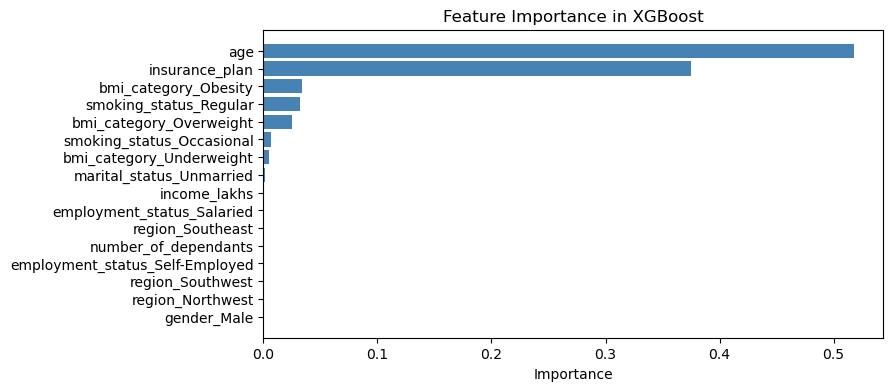

In [58]:
# Plot feature importance
feature_importance = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Importance'])
coef_df = coef_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance in XGBoost')
plt.show()

In [66]:
!pip install streamlit
!pip install jupyter-streamlit


ERROR: Could not find a version that satisfies the requirement jupyter-streamlit (from versions: none)
ERROR: No matching distribution found for jupyter-streamlit
